<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span><ul class="toc-item"><li><span><a href="#Download-data-(if-needed)" data-toc-modified-id="Download-data-(if-needed)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download data (if needed)</a></span></li><li><span><a href="#Read-in-log-file" data-toc-modified-id="Read-in-log-file-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read in log file</a></span></li></ul></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation</a></span><ul class="toc-item"><li><span><a href="#Attempt-w/-ImageDataGenerator" data-toc-modified-id="Attempt-w/-ImageDataGenerator-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Attempt w/ <code>ImageDataGenerator</code></a></span></li><li><span><a href="#Flip-the-image" data-toc-modified-id="Flip-the-image-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Flip the image</a></span></li><li><span><a href="#Adjust-off-center-images" data-toc-modified-id="Adjust-off-center-images-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Adjust off-center images</a></span></li><li><span><a href="#Don't-use-some-small-steering-values" data-toc-modified-id="Don't-use-some-small-steering-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Don't use some small steering values</a></span></li></ul></li><li><span><a href="#Creating-own-generator-to-read-data" data-toc-modified-id="Creating-own-generator-to-read-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating own generator to read data</a></span><ul class="toc-item"><li><span><a href="#Read-in-images-by-path-from-log-file" data-toc-modified-id="Read-in-images-by-path-from-log-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Read in images by path from log file</a></span></li><li><span><a href="#Split-the-data-into-training-and-validation" data-toc-modified-id="Split-the-data-into-training-and-validation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Split the data into training and validation</a></span><ul class="toc-item"><li><span><a href="#Generators-for-both-train-and-validation-sets" data-toc-modified-id="Generators-for-both-train-and-validation-sets-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Generators for both train and validation sets</a></span></li></ul></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Using-center-images-only" data-toc-modified-id="Using-center-images-only-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Using center images only</a></span><ul class="toc-item"><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import cv2
import sklearn
import sklearn.model_selection
import tensorflow.keras as keras

# Load the Data

We'll load the log data & also load the images (found in the log file).

## Download data (if needed)

In [2]:
# Download data & unzip if it doesn't already exist
import os.path
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [3]:
def load_ext_file(data_zip_url, data_path='data/'):
    '''Download the zip file from URL and extract it to path (if specified).
    '''
    # Check if path already exits
    if not os.path.exists(data_path):
        with urlopen(data_zip_url) as zip_resp:
            with ZipFile(BytesIO(zip_resp.read())) as zfile:
                # Extract files into the data directory
                zfile.extractall(path=None)
       

In [4]:
# Use particular release for data from a simulation run
load_ext_file('https://github.com/MrGeislinger/clone-driving-behavior/releases/download/v0.9.0/data.zip')

## Read in log file

In [5]:
def create_img_meas_dfs(log_csv, data_dir=None, orig_dir=None, skiprows=None):
    '''Creates DataFrames for the image paths and measurements using CSV path.
    
    Returns tuple of two DataFrames.
    '''
    data_header = [
        'image_center',
        'image_left',
        'image_right',
        'steer_angle', # [-1,1]
        'throttle', # boolen (if accelerating)
        'break', # boolean (if breaking)
        'speed' # mph
    ]

    df = pd.read_csv(
        log_csv,
        names=data_header,
        skiprows=skiprows
    )

    # Replace the original directory from dataset (if specified)
    if orig_dir and data_dir:
        for col in ['image_center','image_left','image_right']:
            df[col] = df[col].str.replace(orig_dir,data_dir)
    
    # Get specifics for each DF
    df_img_paths = df.iloc[:,:3]
    df_measurments = df.iloc[:,3:]
    
    return df_img_paths,df_measurments, df

In [6]:
df_imgs, df_meas, df_all = create_img_meas_dfs(
    log_csv='data/driving_log.csv', 
    skiprows=1)

display(df_imgs.head())

print('Stats for measurements:')
display(df_meas.describe())

,image_center,image_left,image_right
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg


Stats for measurements:


,steer_angle,throttle,break,speed
count,18455.000000,18455.000000,18455.000000,18455.000000
mean,-0.018091,0.523198,0.001169,23.439675
std,0.116759,0.463944,0.027849,8.038874
min,-0.942695,0.000000,0.000000,0.502490
25%,-0.063718,0.000000,0.000000,16.625330
50%,-0.008961,0.630130,0.000000,27.917360
75%,0.000000,0.985533,0.000000,30.186540
max,1.000000,1.000000,1.000000,30.709360


# Data Augmentation

We can do some data augmentation to the images to have more variety in the training material. We'll just do a horizontal flip here and only use the center images.

## Attempt w/ `ImageDataGenerator`

In [7]:
# datagen = keras.preprocessing.image.ImageDataGenerator(
#     horizontal_flip=True, validation_split=0.2)

In [8]:
# Only looking at center images 
# TODO: 
# Known issue for regression problems: https://github.com/keras-team/keras-preprocessing/issues/214
# train_generator = datagen.flow(
#     X_train[:,1,:], y=y_train, batch_size=64, shuffle=True, seed=27, subset='training'
# )
# valid_generator = datagen.flow(
#     X_valid[:,1,:], y=y_valid, batch_size=64, shuffle=True, seed=27, subset='validation'
# )

## Flip the image

We can flip the image and the steering angle to better generalize.

In [9]:
def flip_image(image, target):
    '''Horizontally flip image and target value.
    '''
    image_flipped = np.fliplr(image)
    target_flipped = -target
    return image_flipped, target_flipped
    

## Adjust off-center images

In [10]:
def adjust_offcenter_image(image, target, correction: float = 1e-2,
                                  img_camera_type: str = 'center'):
    '''
    img_camera_type: The type of camera image
    target: The target value (to be adjusted)
    '''
    # TODO: Adjust the target slightly for off-center image
    if img_camera_type == 'left':
        new_target = target + correction
    elif img_camera_type == 'right':
        new_target = target - correction
    # Don't make any correction if unknown or centere
    else: 
        new_target = target
    return image, new_target

## Don't use some small steering values

Since the data is biased towards to low steering (driving straight), randomly drop some of the data to discourage simply driving straight.

In [11]:
def skip_low_steering(steer_value, steer_threshold=0.05, drop_percent=0.2):
    '''
    '''
    # Keep value if greater than threshold or by chance
    return (np.abs(steer_value) > steer_threshold 
            or np.random.rand() > drop_percent)
        

# Creating own generator to read data

In [12]:
def data_generator(X, y ,batch_size=64, center_only=True, data_dir='data/'):
    '''
    Generate a batch of training images and targets from a DataFrame.
    
    Inputs:
        X: array-like of paths to images
        y: array-like of targerts (in order of X)
    '''
    # Loop forever so the generator never terminates
    while True:
        # Shuffle the image paths and targets
        X_final = []
        y_final = []
        X_shuffled, y_shuffled = sklearn.utils.shuffle(X, y, n_samples=batch_size)
        # TODO: investigate speed of zipping
        # We grab the first element since there is 1 column
        for img_path,target in zip(X_shuffled,y_shuffled):
            fname = data_dir+img_path
            img = cv2.imread(fname[0])
            # Skip specifically for the center image (still checks left/right)
            steer_thresh = 0.05
            drop_ratio = 0.4
            if skip_low_steering(target[0], steer_thresh, drop_ratio):
                X_final.append(img)
                y_final.append(target[0])
                # Use horizontally flipped images (new target)
                img_flipped, target_flipped = flip_image(img,target)
                X_final.append(img_flipped)
                y_final.append(target_flipped[0])
            # Check if we should use all images or just center
            if not center_only:
                # Order: center, left, right
                # Corret left image target & add image with target to array
                img_l = cv2.imread(fname[1])
                target_l = adjust_offcenter_image(img, target, 0.3, 'left')
                # Corret right image target & add image with target to array                
                img_r = cv2.imread(fname[2])
                target_r = adjust_offcenter_image(img, target, 0.3, 'right')
                # Check left and right images separately in case they're 
                # adjusted asymetrically
                if skip_low_steering(target_l[0], steer_thresh, drop_ratio):
                    X_final.append(img_l)
                    y_final.append(target_l[0])
                    # Use horizontally flipped images (new target)
                    img_flipped, target_flipped = flip_image(img_l,target_l)
                    X_final.append(img_flipped)
                    y_final.append(target_flipped[0])
                if skip_low_steering(target_r[0], steer_thresh, drop_ratio):
                    X_final.append(img_r)
                    y_final.append(target_r[0])
                    # Use horizontally flipped images (new target)
                    img_flipped, target_flipped = flip_image(img_r,target_r)
                    X_final.append(img_flipped)
                    y_final.append(target_flipped[0])
                

              
        batch_x = np.array(X_final)
        batch_y = np.array(y_final)
        yield (batch_x, batch_y)

## Read in images by path from log file

We'll use the generator created above to read in images by a batch while training (and validating). But to ensure it works, let's test it out below.

In [13]:
# Note the multiple images will keep the proper shape
temp_generator = data_generator(
    df_all[['image_center','image_left','image_right']].values,
    df_all['steer_angle'].values.reshape(-1,1)
)

In [14]:
imgs,targets = next(temp_generator)

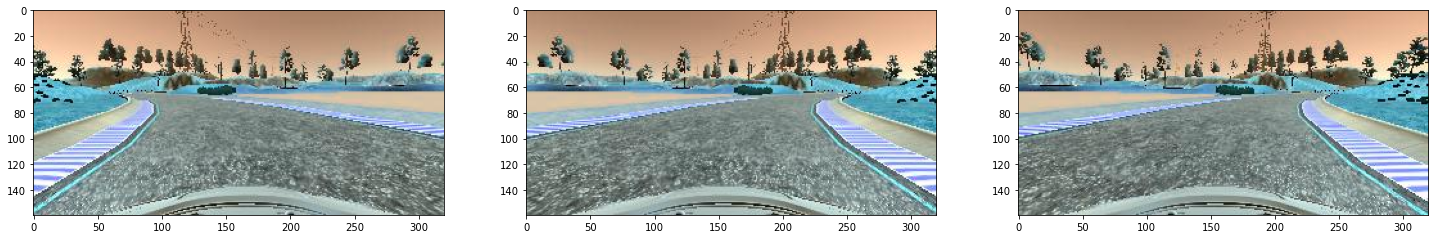

In [15]:
# Test to see if image reading works
import matplotlib.pyplot as plt

f = plt.figure(figsize=(25,25))
ax_left = f.add_subplot(1, 3, 1)
ax_center = f.add_subplot(1, 3, 2)
ax_right = f.add_subplot(1, 3, 3)


# Print out three image examples
ax_center.imshow(imgs[0])
ax_left.imshow(imgs[1])
ax_right.imshow(imgs[2])

## Split the data into training and validation

In [16]:
# Adjust the target for off-center images to be used in training
X = df_all[['image_center','image_left','image_right']].values
y = df_all[['steer_angle']].values

In [17]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
                                        X, y, test_size=0.2, random_state=27)

### Generators for both train and validation sets

In [18]:
# Using reasobable batch size so GPU can process enough images
train_generator = data_generator(X_train, y_train, batch_size=128)
valid_generator = data_generator(X_valid, y_valid, batch_size=64)

# Model

## Using center images only

We'll try just using center images for training the model. If we simply put in the left and right images for the camera angle, we'd likely have issues with the model learning incorrect behavior. There are some techniques that could allow us to use these other images but for simplicity's sake we'll only use the center images for now.

In [19]:
# Creating a resuable default convolution
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_initializer='he_normal',
                        kernel_size=3, activation='relu', padding='SAME')

In [20]:
input_shape = (160,320,3)

In [21]:
# Based on https://developer.nvidia.com/blog/deep-learning-self-driving-cars/
# Max Pooling allows images to run more reasonably through GPU & CPU
model_list = [
    # Normalize the images
    keras.layers.Lambda(lambda x: (x/255.0) - 0.5, input_shape=input_shape),
    DefaultConv2D(filters=24, kernel_size=5),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=36, kernel_size=5),
    keras.layers.MaxPooling2D(pool_size=2), 
    DefaultConv2D(filters=48, kernel_size=5),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.4),  # Dropout to regularize
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),    
    keras.layers.Dropout(0.5),  # Dropout to regularize
    # Fully connected network
    keras.layers.Flatten(),
    keras.layers.Dense(units=1024, activation='relu'),
    keras.layers.Dropout(0.2),  # Dropout to regularize
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.2),  # Dropout to regularize
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=1)
]

In [22]:
# Adding in model to crop images first
model_list = (
    [model_list[0]] +
    # Crop out "unnecessary parts of the image"
    [keras.layers.Cropping2D(cropping=((60,20), (0,0)))] +
    model_list[1:]
)

In [23]:
model = keras.models.Sequential(model_list)

In [24]:
model.compile(
    loss='mse', 
    optimizer='nadam'
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 320, 24)       1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 160, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 160, 36)       21636     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 80, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 80, 48)        4

In [26]:
# Allow early stopping after not changing
stop_after_no_change = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=16,
    restore_best_weights=True
)

In [27]:
history = model.fit(
    x=train_generator,
    y=None, # Since using a generator
    batch_size=None, # Since using a generator
    epochs=256, # Large since we want to ensure we stop by early stopping
    steps_per_epoch=128, # Ideal: steps*batch_size = # of images
    validation_data=valid_generator,
    validation_steps=32,
    callbacks=[stop_after_no_change]
)

Epoch 1/256
128/128 [==============================] - 41s 317ms/step - loss: 0.0274 - val_loss: 0.0138
Epoch 2/256
128/128 [==============================] - 28s 217ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 3/256
128/128 [==============================] - 27s 211ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 4/256
128/128 [==============================] - 26s 203ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 5/256
128/128 [==============================] - 27s 210ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 6/256
128/128 [==============================] - 26s 200ms/step - loss: 0.0069 - val_loss: 0.0084
Epoch 7/256
128/128 [==============================] - 25s 199ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 8/256
128/128 [==============================] - 26s 200ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 9/256
128/128 [==============================] - 25s 198ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 10/256
128/128 [==============================] - 26s 206m

### Evaluation

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 

def eval_model(model, model_history, X, y, show=True):
    '''
    '''
    score = model.evaluate(X, y)
    print(f'Loss: {score:.2f}')

    if show:
        plt.plot(model_history.history['loss'], label='Loss (training data)')
        plt.plot(model_history.history['val_loss'], label='Loss (validation data)')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.show()

Let's checkout how the previous model turned while training.

4/4 [==============================] - 0s 17ms/step - loss: 0.0072
Loss: 0.01


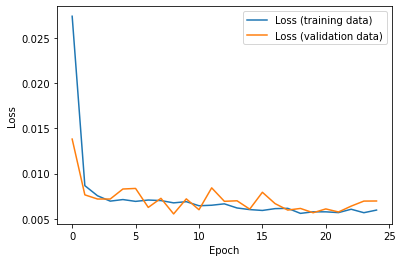

In [29]:
test_generator = data_generator(X_valid, y_valid, batch_size=64)
X_test, y_test = next(test_generator)
eval_model(model, history, X_test, y_test)

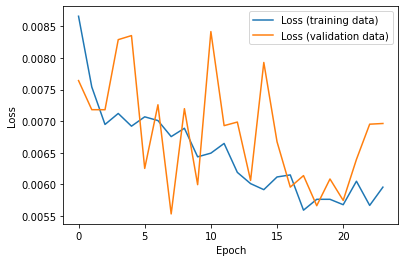

In [30]:
# Ignore the first epoch since it's typically very high compared to the rest
plt.plot(history.history['loss'][1:], label='Loss (training data)')
plt.plot(history.history['val_loss'][1:], label='Loss (validation data)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [31]:
model.save('model.h5')

In [32]:
# Clean up the data downloaded (not needed for output)
!rm -rf data/

In [33]:
!rm -rf __MACOSX/